# R&S ZNB/ZNBT VNA - SCPI over Sockets test program

- **Author:** Juan del Pino Mena
- **Version:** v00
- **Date:** 2024-02-07


---

# Introduction

Execute this notebook on a virtual environment.
https://medium.com/@royce963/setting-up-jupyterlab-and-a-virtual-environment-c79002e0e5f7

## Requirements

- numpy
- matplotlib


## VNA network interface configuration

1. Connect the function generator and your PC to the same local network. **They even can be connected directly via an Ethernet cable.**
2. Make sure you are connected to the same LAN as the VNA, and that they have compatible IP addresses. To check your IP, type `ipconfig` (windows), or `ifconfig` // `ip addr` (linux).
3. For convenience, this guide sets a fixed IP to the VNA.
4. Check if the device is accessible: Do a ping to the device: `ping 10.10.0.152` (windows & linux).

## Fixed IP - VNA IP by default

By default, the VNA has address 10.10.0.152, on a subnetwork with mask /8. Changing the IP is possible but requires an admin password.
In this document, this IP is not changed

## LAN Setup on the R&S ZNB VNA

1. Press the windows key
2. Control panel >> Network and sharing center >> Change adapter settings >> local connection (right click) >> Properties
3. Connection properties >> Internet Protocol Version 4 (TCP/IPv4) >> Properties
4. Enter the IP configuration
    - IP addr: `192.168.1.105`
    - Mask: `255.255.255.0` (/24)
    - Gateway: `192.168.1.1`
5. The port for programming the VNA is always `5025`

## Fixed IP - LAN Setup on PC

- On Linux:
    `sudo ip addr add 10.10.0.151/8 dev enp3s0` (CHANGE `enp3s0` ACCORDING TO THE NAME OF YOUR ETHERNET INTERFACE)
- On Windows: similar steps as in the VNA.


# Conclusions

These tests have served as checks, so we know which commands we must send to configure the VNA and measure data. We will use socketscpi package to do the SCPI over sockets communication with the VNA. It is a simple and effective tool to deal with problems such as buffer overflow when reading a lot of data.



# Tests

In [417]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import socket

host = "10.10.0.152"
port = 5025

s = socket.socket()
s.connect((host,port))
s
# if success, will output:
# <socket.socket fd=55, family=2, type=1, proto=0, laddr=('10.10.0.151', 55132), raddr=('10.10.0.152', 5025)>

ConnectionRefusedError: [Errno 111] Connection refused

In [419]:
s.close  # close connection

<bound method socket.close of <socket.socket fd=69, family=2, type=1, proto=0, laddr=('10.10.0.151', 40722), raddr=('10.10.0.152', 5025)>>

In [426]:
import socket
import time

host = "10.10.0.152"
port = 5025

s = socket.socket()
s.connect((host,port))


def query(MSG):
    s.sendall((MSG + "\n").encode())
    return s.recv(4096).decode()

def send(MSG):
    s.sendall((MSG + "\n").encode())

def querydata(MSG):
    s.sendall((MSG + "\n").encode())
    print (MSG + ' sent')

    RESP=s.recv(1).decode()
    print ('Response detected: ' + RESP)

    DIG=s.recv(1).decode()
    print ('No of data digits: ' + DIG)

    DSize=int(s.recv(int(DIG)))
    print ('No of data bytes: ' + str(DSize))

    Data = bytearray(0)
    while DSize:
        time.sleep(0.1) #Da tiempo al VNA a llenar el buffer
        if DSize >= 4096:
            chunk = s.recv(4096)
            print ('No of bytes received: {0}'.format(len(chunk)))
            Data.extend(chunk)
            DSize = DSize - 4096
        else:
            chunk = s.recv(DSize)
            print ('No of bytes received: {0}'.format(len(chunk)))
            Data.extend(chunk)
            DSize = 0

    return Data


In [427]:
query('*IDN?')
# 'Rohde-Schwarz,ZNB20-2Port,1311601062101657,3.32\n'

'Rohde-Schwarz,ZNB20-2Port,1311601062101657,3.32\n'

In [461]:
# reset and 

send("*RST")  # reset
send("INIT:CONT:ALL OFF")  # disables continuous mode even for new traces
send("CALC:PAR:DEL:ALL")  # delete all traces -- black screen

In [455]:
# send("FORM REAL, 32")  # pag 1008  - 32 bit format  # WILL GIVE ERROR WHEN READING? WTF
# send("FORM:BORD NORM")  # pag 1009  - normal (not swapped) byte order

In [462]:
# Establishes start, stop and number of points

Fmin = 1e9  # Hz
Fmax = 10e9  # Hz
NPoints = 21  # points

send('SENS:FREQ:STAR ' + str(Fmin))
send('SENS:FREQ:STOP ' + str(Fmax))
send('SENS:SWE:POIN ' + str(NPoints))

In [463]:
# Pag 864: CALCulate<Ch>:PARameter:SELect <TraceName>
# create new traces with defined measurements

# channel 1 -  magnitude, logarithmic (dB) and phases (deg)

send("CALC:PAR:SDEF 'Trc1_mlog', 'S11'")
send("CALC:PAR:SEL 'Trc1_mlog'")
send("CALC:FORM MLOG")  # dB - pag 807

time.sleep(0.1)

send("CALC:PAR:SDEF 'Trc1_phas', 'S11'")
send("CALC:PAR:SEL 'Trc1_phas'")
send("CALC:FORM PHAS")  # phase -180 to 180 - pag 807

time.sleep(0.1)

send("CALC:PAR:SDEF 'Trc2_mlog', 'S12'")
send("CALC:PAR:SEL 'Trc2_mlog'")
send("CALC:FORM MLOG")

time.sleep(0.1)

send("CALC:PAR:SDEF 'Trc2_phas', 'S12'")
send("CALC:PAR:SEL 'Trc2_phas'")
send("CALC:FORM PHAS")

time.sleep(0.1)

send("CALC:PAR:SDEF 'Trc3_mlog', 'S21'")
send("CALC:PAR:SEL 'Trc3_mlog'")
send("CALC:FORM MLOG")

time.sleep(0.1)

send("CALC:PAR:SDEF 'Trc3_phas', 'S21'")
send("CALC:PAR:SEL 'Trc3_phas'")
send("CALC:FORM PHAS")

time.sleep(0.1)

send("CALC:PAR:SDEF 'Trc4_mlog', 'S22'")
send("CALC:PAR:SEL 'Trc4_mlog'")
send("CALC:FORM MLOG")

time.sleep(0.1)

send("CALC:PAR:SDEF 'Trc4_phas', 'S22'")
send("CALC:PAR:SEL 'Trc4_phas'")
send("CALC:FORM PHAS")

time.sleep(0.1)

In [464]:
query("CALC:PAR:CAT?")  # ask what traces are created (for confirmation)

"'Trc1_mlog,S11,Trc1_phas,S11,Trc2_mlog,S12,Trc2_phas,S12,Trc3_mlog,S21,Trc3_phas,S21,Trc4_mlog,S22,Trc4_phas,S22'\n"

In [465]:
query("CALC:PAR:SEL?")  # trace 4 phase (last declared) if the above code is executed corectly

"'Trc4_phas'\n"

In [466]:
# display traces on the screen

send("DISP:WIND1:STAT ON")

send("DISP:WIND1:TRAC1:FEED 'Trc1_mlog'")
send("DISP:WIND1:TRAC2:FEED 'Trc2_mlog'")
send("DISP:WIND1:TRAC3:FEED 'Trc3_mlog'")
send("DISP:WIND1:TRAC4:FEED 'Trc4_mlog'")

send("DISP:WIND1:TRAC5:FEED 'Trc1_phas'")
send("DISP:WIND1:TRAC6:FEED 'Trc2_phas'")
send("DISP:WIND1:TRAC7:FEED 'Trc3_phas'")
send("DISP:WIND1:TRAC8:FEED 'Trc4_phas'")

In [467]:
send("INIT:IMM; *WAI")  # single sweep. Waits until completed before proceeding with next command

In [468]:
# old command -- will give an error

# querydata('CALC:DATA:SNP? 2')  # does not respond

In [496]:
DATA = query("CALC:DATA:ALL? FDAT")  
# Reading without buffer rotation. 
# Will overflow the buffer and give errors in other commands if many points are retrieved

# Data order: as declared above:
# Trc1,S11,mlog, Trc1,S11,phas
# Trc2,S12,mlog, Trc2,S12,phas
# Trc3,S21,mlog, Trc3,S21,phas
# Trc4,S22,mlog, Trc4,S22,phas

# Reshape: 8 columns (mag+phase per S-param), of NPoints rows.

DATA  # data without column delimiter. We must reshape accordingly to the known matrix size.

'-0.44137678317,-0.57587526652,-0.77711458881,-0.88587686068,-0.94045106751,-0.87544792669,-0.83754941742,-0.85634038477,-0.97404234558,-1.203082808,-1.434191991,-1.551163223,-1.4892440869,-1.3523548768,-1.1722036753,-1.136787926,-1.2802760407,-1.5557830254,-1.8092116908,-1.9544072348,-1.922377023,-16.143367413,-76.603381857,-135.92158413,164.72708713,103.66863327,44.716220676,-15.801177509,-77.025968094,-138.04753537,161.06520941,101.44760959,44.059186251,-14.479288635,-71.752888609,-134.45781152,164.79896811,103.25097527,41.883798013,-16.437711648,-76.814949506,-134.7051416,-80.144020812,-88.191008786,-82.134742492,-80.071685687,-112.3599141,-89.30704359,-85.54616112,-97.907787375,-85.04797953,-85.568382901,-85.010818301,-85.619490915,-85.978940544,-89.774823323,-85.209145915,-87.069228286,-85.941612368,-88.713892489,-80.21174413,-97.667710351,-91.127718144,134.30349797,-158.90323092,29.957365866,0.76287735112,4.275794272,58.676002012,-147.85158927,-56.183628812,-139.0680735,167.4918

In [497]:
DATA2 = np.array([float(item) for item in DATA.split(",")])  # from string to array of floats
DATA3 = DATA2.reshape(8, NPoints)  # Reshape: 8 columns, of NPoints rows.
print(f"Shape = {np.shape(DATA3)}")
DATA3

Shape = (8, 21)


array([[  -0.44137678,   -0.57587527,   -0.77711459,   -0.88587686,
          -0.94045107,   -0.87544793,   -0.83754942,   -0.85634038,
          -0.97404235,   -1.20308281,   -1.43419199,   -1.55116322,
          -1.48924409,   -1.35235488,   -1.17220368,   -1.13678793,
          -1.28027604,   -1.55578303,   -1.80921169,   -1.95440723,
          -1.92237702],
       [ -16.14336741,  -76.60338186, -135.92158413,  164.72708713,
         103.66863327,   44.71622068,  -15.80117751,  -77.02596809,
        -138.04753537,  161.06520941,  101.44760959,   44.05918625,
         -14.47928863,  -71.75288861, -134.45781152,  164.79896811,
         103.25097527,   41.88379801,  -16.43771165,  -76.81494951,
        -134.7051416 ],
       [ -80.14402081,  -88.19100879,  -82.13474249,  -80.07168569,
        -112.3599141 ,  -89.30704359,  -85.54616112,  -97.90778737,
         -85.04797953,  -85.5683829 ,  -85.0108183 ,  -85.61949092,
         -85.97894054,  -89.77482332,  -85.20914591,  -87.06922829,


In [498]:
f = np.linspace(Fmin, Fmax, NPoints)  # frequency vector, for plotting

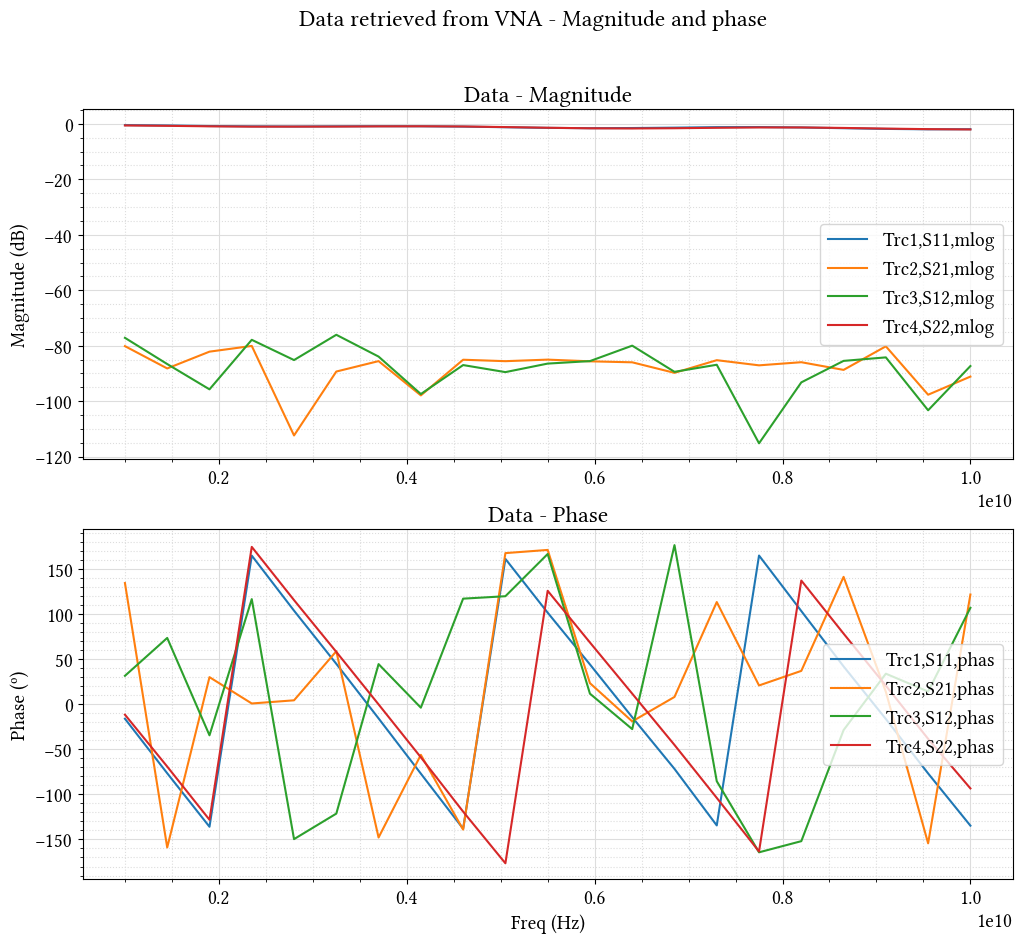

In [499]:
# plotting to confirm reading works - should be the same as in the screen

import numpy as np
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, figsize=[12, 10])

fig.suptitle("Data retrieved from VNA - Magnitude and phase")
ax1.set_title('Data - Magnitude')
# ax1.set_xlabel('Freq (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax2.set_title('Data - Phase')
ax2.set_xlabel('Freq (Hz)')
ax2.set_ylabel('Phase (º)')

ax1.plot(f, DATA3[0][:], label="Trc1,S11,mlog")
ax1.plot(f, DATA3[2][:], label="Trc2,S21,mlog")
ax1.plot(f, DATA3[4][:], label="Trc3,S12,mlog")
ax1.plot(f, DATA3[6][:], label="Trc4,S22,mlog")

ax1.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.8)
ax1.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
ax1.minorticks_on()
ax1.legend(loc="center right")


plt.plot(f, DATA3[1][:], label="Trc1,S11,phas")
plt.plot(f, DATA3[3][:], label="Trc2,S21,phas")
plt.plot(f, DATA3[5][:], label="Trc3,S12,phas")
plt.plot(f, DATA3[7][:], label="Trc4,S22,phas")

ax2.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.8)
ax2.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
ax2.minorticks_on()
ax2.legend(loc="center right")



plt.show()

In [494]:
querydata("CALCulate:DATA:ALL? FDAT")

CALCulate:DATA:ALL? FDAT sent
Response detected: -
No of data digits: 0


ValueError: invalid literal for int() with base 10: b''

In [509]:
# empty buffer

def recvall(sock):
    BUFF_SIZE = 4096 # 4 KiB
    data = b''
    while True:
        part = sock.recv(BUFF_SIZE)
        print(len(part))
        data += part
        if len(part) < BUFF_SIZE:
            # either 0 or end of data
            break
    return data

recvall(s)

KeyboardInterrupt: 

In [416]:
query('*IDN?')
# 'Rohde-Schwarz,ZNB20-2Port,1311601062101657,3.32\n'

'Rohde-Schwarz,ZNB20-2Port,1311601062101657,3.32\n'

In [500]:
query('*OPC?')

'1\n'

In [136]:
MSG = "CALC:DATA:ALL? FDAT"

s.sendall((MSG + "\n").encode())
print (MSG + ' sent')

CALC:DATA:ALL? FDAT sent


In [ ]:
resp_comp = s.recv(1).decode()

In [137]:
respuesta_completa

RESP=
print ('Response detected: ' + RESP)


Response detected: -


In [138]:

DIG=s.recv(1).decode()
print ('No of data digits: ' + DIG)


No of data digits: 0


In [141]:
int(DIG)

0

In [143]:
s.recv(int(DIG)).decode()

''

In [144]:
DSize=int(s.recv(int(DIG)).decode())
print ('No of data bytes: ' + str(DSize))

ValueError: invalid literal for int() with base 10: ''

In [ ]:

Data = bytearray(0)
while DSize:
    time.sleep(0.1) #Da tiempo al VNA a llenar el buffer
    if DSize >= 4096:
        chunk = s.recv(4096)
        print ('No of bytes received: {0}'.format(len(chunk)))
        Data.extend(chunk)
        DSize = DSize - 4096
    else:
        chunk = s.recv(DSize)
        print ('No of bytes received: {0}'.format(len(chunk)))
        Data.extend(chunk)
        DSize = 0

In [ ]:
send("FORM:BORD SWAP")
send("FORM REAL 32")

In [547]:
import socketscpi
import numpy as np
import time


def vna_example(ipAddress, port=5025):
    """
    Test all commands from above and get a data response
    """
    
    vna = socketscpi.SocketInstrument(ipAddress=ipAddress, port=port, timeout=10)
    print(vna.instId)

    vna.write("*RST")  # reset
    vna.write("INIT:CONT:ALL OFF")  # disables continuous mode even for new traces
    vna.write("CALC:PAR:DEL:ALL")  # delete all traces -- black screen
    
    vna.write("*WAI")  # Waits until completed before proceeding with next command
    
    # Establishes start, stop and number of points
    
    Fmin = 1e9  # Hz
    Fmax = 9e9  # Hz
    NPoints = 101  # points
    
    vna.write('SENS:FREQ:STAR ' + str(Fmin))
    vna.write('SENS:FREQ:STOP ' + str(Fmax))
    vna.write('SENS:SWE:POIN ' + str(NPoints))
    
    vna.write("*WAI")  # Waits until completed before proceeding with next command
    
    # Pag 864: CALCulate<Ch>:PARameter:SELect <TraceName>
    # create new traces with defined measurements
    
    # channel 1 -  magnitude, logarithmic (dB) and phases (deg)
    
    vna.write("CALC:PAR:SDEF 'Trc1_mlog', 'S11'")
    vna.write("CALC:PAR:SEL 'Trc1_mlog'")
    vna.write("CALC:FORM MLOG")  # dB - pag 807
    
    vna.write("CALC:PAR:SDEF 'Trc1_phas', 'S11'")
    vna.write("CALC:PAR:SEL 'Trc1_phas'")
    vna.write("CALC:FORM PHAS")  # phase -180 to 180 - pag 807
    
    vna.write("CALC:PAR:SDEF 'Trc2_mlog', 'S12'")
    vna.write("CALC:PAR:SEL 'Trc2_mlog'")
    vna.write("CALC:FORM MLOG")
    
    vna.write("CALC:PAR:SDEF 'Trc2_phas', 'S12'")
    vna.write("CALC:PAR:SEL 'Trc2_phas'")
    vna.write("CALC:FORM PHAS")
    
    vna.write("CALC:PAR:SDEF 'Trc3_mlog', 'S21'")
    vna.write("CALC:PAR:SEL 'Trc3_mlog'")
    vna.write("CALC:FORM MLOG")
    
    vna.write("CALC:PAR:SDEF 'Trc3_phas', 'S21'")
    vna.write("CALC:PAR:SEL 'Trc3_phas'")
    vna.write("CALC:FORM PHAS")
    
    vna.write("CALC:PAR:SDEF 'Trc4_mlog', 'S22'")
    vna.write("CALC:PAR:SEL 'Trc4_mlog'")
    vna.write("CALC:FORM MLOG")
    
    vna.write("CALC:PAR:SDEF 'Trc4_phas', 'S22'")
    vna.write("CALC:PAR:SEL 'Trc4_phas'")
    vna.write("CALC:FORM PHAS")
    
    vna.write("*WAI")  # Waits until completed before proceeding with next command
    
    
    # display traces on the screen
    
    vna.write("DISP:WIND1:STAT ON")
    
    vna.write("DISP:WIND1:TRAC1:FEED 'Trc1_mlog'")
    vna.write("DISP:WIND1:TRAC2:FEED 'Trc2_mlog'")
    vna.write("DISP:WIND1:TRAC3:FEED 'Trc3_mlog'")
    vna.write("DISP:WIND1:TRAC4:FEED 'Trc4_mlog'")
    
    vna.write("DISP:WIND1:TRAC5:FEED 'Trc1_phas'")
    vna.write("DISP:WIND1:TRAC6:FEED 'Trc2_phas'")
    vna.write("DISP:WIND1:TRAC7:FEED 'Trc3_phas'")
    vna.write("DISP:WIND1:TRAC8:FEED 'Trc4_phas'")
    
    vna.write("INIT:IMM; *WAI")  # single sweep. Waits until completed before proceeding with next

    # vna.write("*WAI")  # Waits until completed before proceeding with next command
    
    # vna.write('system:fpreset')
    # vna.query('*opc?')

    # measName = 'meas1'
    # vna.write('display:window1:state on')
    # vna.write(f'calc1:parameter:define "{measName}", "S11"')
    # vna.write(f'display:window1:trace1:feed "{measName}"')
    # vna.write(f'calc1:parameter:select "{measName}"')

    # vna.write('initiate:continuous off')
    # vna.write('initiate:immediate')
    # vna.query('*opc?')
    # vna.write('display:window1:y:auto')

    vna.write('format:border swap')
    vna.write('format real,32')
    
    vna.write("*WAI")  # Waits until completed before proceeding with next command

    meas = vna.query_binary_values('calculate:data:all? fdata', datatype='f')
    
    vna.query('*opc?')

    # freq = vna.query_binary_values('calculate1:x?', datatype='d')
    # vna.query('*opc?')

    vna.err_check()
    vna.close()

    return meas

In [548]:
Fmin = 1e9  # Hz
Fmax = 9e9  # Hz
NPoints = 101  # points

host = "10.10.0.152"
port = 5025

MEAS = vna_example(host, port)
MEAS

Rohde-Schwarz,ZNB20-2Port,1311601062101657,3.32


array([ -30.854778  ,  -29.34792   ,  -29.298283  ,  -25.769405  ,
        -27.29256   ,  -23.868244  ,  -25.744465  ,  -24.9642    ,
        -23.952452  ,  -22.730268  ,  -25.085724  ,  -24.329266  ,
        -24.78488   ,  -27.10969   ,  -24.563162  ,  -23.609007  ,
        -24.55212   ,  -21.236702  ,  -24.9104    ,  -23.18218   ,
        -22.718246  ,  -25.420235  ,  -23.311035  ,  -22.09933   ,
        -23.731676  ,  -27.056688  ,  -24.796886  ,  -26.02216   ,
        -24.867495  ,  -25.044909  ,  -27.0606    ,  -24.538584  ,
        -24.946575  ,  -26.040188  ,  -23.019224  ,  -29.17543   ,
        -24.118387  ,  -22.90928   ,  -26.100182  ,  -23.333244  ,
        -24.725044  ,  -23.472675  ,  -26.377645  ,  -24.587997  ,
        -23.93702   ,  -26.686937  ,  -23.343647  ,  -23.458008  ,
        -26.224407  ,  -24.616158  ,  -23.83892   ,  -23.99058   ,
        -23.2951    ,  -23.439978  ,  -23.530602  ,  -23.133987  ,
        -22.997574  ,  -23.968029  ,  -22.240881  ,  -23.05734

In [549]:
MEAS3 = MEAS.reshape(8, NPoints)  # Reshape: 8 columns, of NPoints rows.
print(f"Shape = {np.shape(MEAS3)}")
MEAS3

Shape = (8, 101)


array([[ -30.854778  ,  -29.34792   ,  -29.298283  ,  -25.769405  ,
         -27.29256   ,  -23.868244  ,  -25.744465  ,  -24.9642    ,
         -23.952452  ,  -22.730268  ,  -25.085724  ,  -24.329266  ,
         -24.78488   ,  -27.10969   ,  -24.563162  ,  -23.609007  ,
         -24.55212   ,  -21.236702  ,  -24.9104    ,  -23.18218   ,
         -22.718246  ,  -25.420235  ,  -23.311035  ,  -22.09933   ,
         -23.731676  ,  -27.056688  ,  -24.796886  ,  -26.02216   ,
         -24.867495  ,  -25.044909  ,  -27.0606    ,  -24.538584  ,
         -24.946575  ,  -26.040188  ,  -23.019224  ,  -29.17543   ,
         -24.118387  ,  -22.90928   ,  -26.100182  ,  -23.333244  ,
         -24.725044  ,  -23.472675  ,  -26.377645  ,  -24.587997  ,
         -23.93702   ,  -26.686937  ,  -23.343647  ,  -23.458008  ,
         -26.224407  ,  -24.616158  ,  -23.83892   ,  -23.99058   ,
         -23.2951    ,  -23.439978  ,  -23.530602  ,  -23.133987  ,
         -22.997574  ,  -23.968029  ,  -22.24088

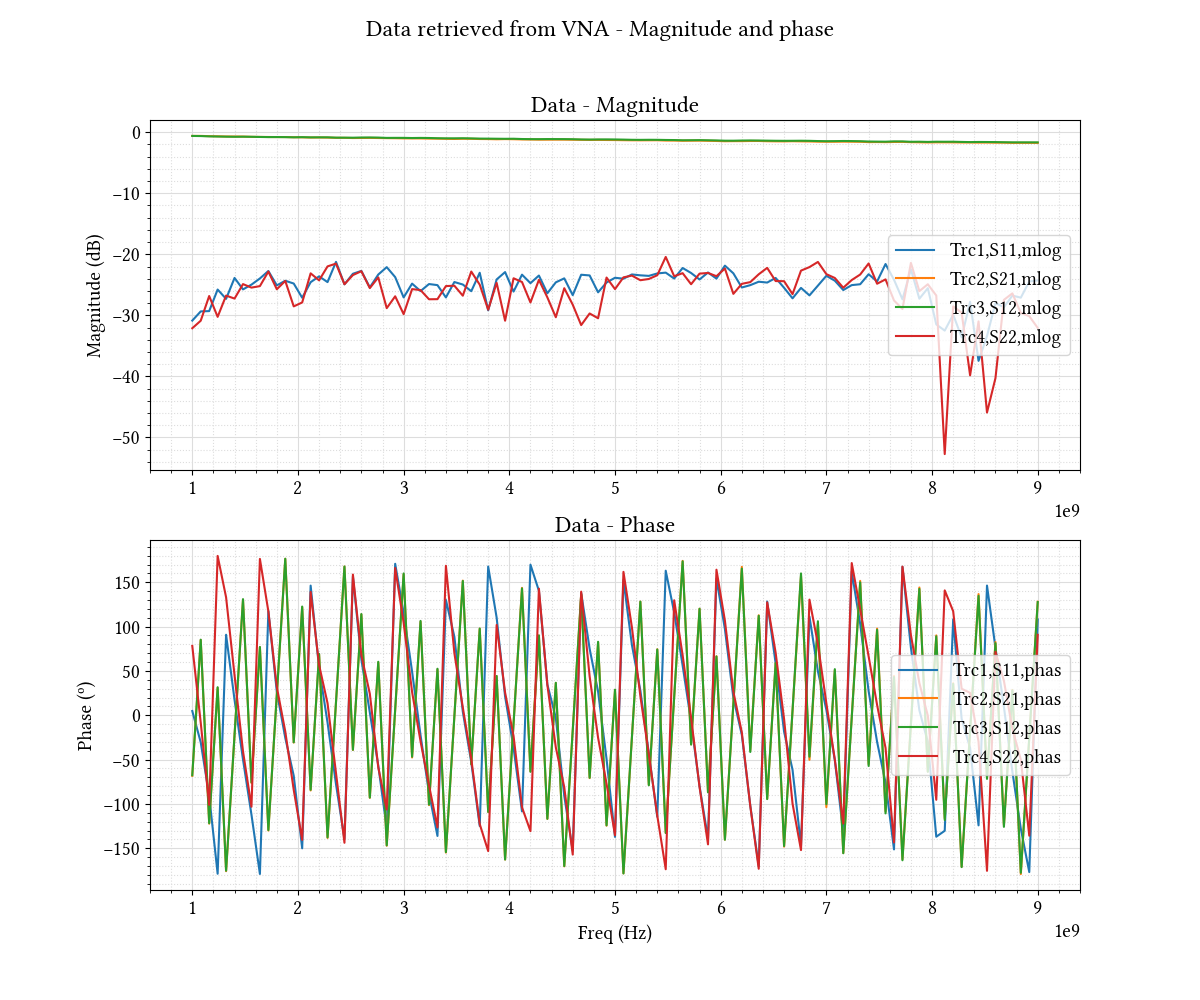

In [554]:
# plotting to confirm reading works - should be the same as in the screen

import numpy as np
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, figsize=[12, 10])

f = np.linspace(Fmin, Fmax, NPoints)  # frequency vector, for plotting

fig.suptitle("Data retrieved from VNA - Magnitude and phase")
ax1.set_title('Data - Magnitude')
# ax1.set_xlabel('Freq (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax2.set_title('Data - Phase')
ax2.set_xlabel('Freq (Hz)')
ax2.set_ylabel('Phase (º)')

ax1.plot(f, MEAS3[0][:], label="Trc1,S11,mlog")
ax1.plot(f, MEAS3[2][:], label="Trc2,S21,mlog")
ax1.plot(f, MEAS3[4][:], label="Trc3,S12,mlog")
ax1.plot(f, MEAS3[6][:], label="Trc4,S22,mlog")

ax1.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.8)
ax1.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
ax1.minorticks_on()
ax1.legend(loc="center right")


plt.plot(f, MEAS3[1][:], label="Trc1,S11,phas")
plt.plot(f, MEAS3[3][:], label="Trc2,S21,phas")
plt.plot(f, MEAS3[5][:], label="Trc3,S12,phas")
plt.plot(f, MEAS3[7][:], label="Trc4,S22,phas")

ax2.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.8)
ax2.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
ax2.minorticks_on()
ax2.legend(loc="center right")



plt.show()